概要：子会社の売上およびその他の勘定科目における予測モデルの構築

目的：予算や税金（法人税）の最適化を行うための前段として、予測モデルを構築する

手法：時系列分析を用いる。今回は時系列分析の基礎となる考え方をマスターするため、古典的な手法であるSARIMAX（ARIMAなども含む）に取り組む

流れ
1　前処理
2　グリッドサーチ
3　モデル構築
4　ADF検定とSTL分解

# 1　前処理

①ライブラリ、モジュール読み込み

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from scipy import stats

import seaborn as sns

②データ読み込み
今回はTableauで使用している元データを使い、実施した。
＊経理は管理会計と財務会計に分かれ、財務会計に使用されるデータが活用できるものが３年前からになる。
＊管理会計と財務会計の違いは見せる相手の対象である。管理会計は社内向け、財務会計では社外向けの資料となる。

In [ ]:
df_2023 = pd.read_table('.txt', header=None, sep=' ' )
df_2022 = pd.read_table('.txt', header=None, sep=' ' )
df_2021 = pd.read_table('.txt', header=None, sep=' ' )
df_2021 = pd.read_tabale('', header=None, sep)

<ipython-input-2-2bebe7f2fe07>:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2023 = pd.read_table('/content/drive/Shareddrives/01_組織_TSS_財務経理本部/子会社経理資料/会計データ/JOURNAL_SLIP/2023/LEDGER_BALANCE.txt', header=None, sep=' ' )
<ipython-input-2-2bebe7f2fe07>:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2022 = pd.read_table('/content/drive/Shareddrives/01_組織_TSS_財務経理本部/子会社経理資料/会計データ/JOURNAL_SLIP/2022/LEDGER_BALANCE.txt', header=None, sep=' ' )
<ipython-input-2-2bebe7f2fe07>:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2021 = pd.read_table('/content/drive/Shareddrives/01_組織_TSS_財務経理本部/子会社経理資料/会計データ/JOURNAL_SLIP/2021/LEDGER_BALANCE.txt', header=None, sep=' ' )


③前処理（時系列分析では、基本的に２列だけにするイメージ。1列目は日付、2列目は売上などの目的変数）

In [ ]:
#余分な”-”を削除する
df_2023 = df_2023.drop(columns=10)
df_2022 = df_2022.drop(columns=10)
df_2021 = df_2021.drop(columns=10)

In [ ]:
#それぞれを結合する
df = pd.concat([df_2023,df_2022,df_2021])

In [ ]:
#カラム名を追加する
df.columns = ['会社コード','会計年度','会計月度','仕訳種類','決算種別','計上組織コード','貸借区分','勘定科目コード','補助科目コード','取引先コード','金額']

In [ ]:
#勘定科目名が売上高に焦点を当てたいので、勘定科目コードを811200を設定する。
df_uriage = (df['勘定科目コード']==811200)
df = df.loc[df_uriage]

In [ ]:
df

,会社コード,会計年度,会計月度,仕訳種類,決算種別,計上組織コード,貸借区分,勘定科目コード,補助科目コード,取引先コード,金額
624201,1001,2023,1,1,0,10010308003200,1,811200,9999,T020017712,11285093
624202,1001,2023,2,1,0,10010308003200,1,811200,9999,T020017712,9808570
624203,1001,2023,3,1,0,10010106000100,1,811200,9999,T020017712,8135260
624204,1001,2023,4,1,0,10010106000100,1,811200,9999,T020017712,7356297
624205,1001,2023,5,1,0,10010106000100,1,811200,9999,T020017712,6840463
...,...,...,...,...,...,...,...,...,...,...,...
1660759,2018,2021,9,1,0,20180308048500,1,811200,9999,_,7533
1660760,2018,2021,10,1,0,20180308048500,1,811200,9999,_,2200
1660761,2018,2021,11,1,0,20180308048500,1,811200,9999,_,240
1660762,2018,2021,11,1,0,20180000000000,1,811200,9999,_,1000


In [ ]:
#合計売上高を目的変数とするため、グループ化する。
df = df.groupby(['会計年度', '会計月度', '貸借区分'])[['金額']].sum()

＊注意点
貸借の概念：簡単に言うと+と-捉えてOK
以降で貸借計算を行い、合計金額を算出する。


In [ ]:
df

金額
会計年度 会計月度 貸借区分             
2021 1    1     50667983203
     2    0           37674
          1     51583365395
     3    1     46126125237
     4    0           32937
...                     ...
2023 9    1     62801894731
     10   0        21013640
          1     57840222971
     11   1     45135633697
     12   0        16507753

[68 rows x 1 columns]

### 上記のテーブルは貸借区分は1が借方、0が貸方であることから、借方から貸方を引いた値が真の合計金額である。このままのDFでは計算することができないため、下記の処理を行う。

In [ ]:
df = df.pivot_table(index=['会計年度', '会計月度'], columns='貸借区分')

In [ ]:
#マルチインデックスのため、タプルにて指定している。注意としては、データの型に注意して行う必要がある。
df.loc[(2021,1),('金額', 0)] = 0
df.loc[(2021,3), ('金額', 0)] = 0

In [ ]:
#合計金額のカラムを新規に作成する
df['合計金額'] = df[('金額', 1)] - df[('金額', 0)]

In [ ]:
df

金額                        合計金額
貸借区分                 0             1              
会計年度 会計月度                                         
2021 1             0.0  5.066798e+10  5.066798e+10
     2         37674.0  5.158337e+10  5.158333e+10
     3             0.0  4.612613e+10  4.612613e+10
     4         32937.0  4.986988e+10  4.986985e+10
     5         49978.0  4.744076e+10  4.744071e+10
     6        678947.0  5.651740e+10  5.651672e+10
     7      24235474.0  4.796130e+10  4.793706e+10
     8         19548.0  4.396039e+10  4.396037e+10
     9     226367026.0  5.031724e+10  5.009087e+10
     10    226257042.0  4.923380e+10  4.900754e+10
     11       343687.0  5.145012e+10  5.144978e+10
     12      6747297.0  4.948595e+10  4.947920e+10
2022 1       1297952.0  5.370360e+10  5.370231e+10
     2       1867307.0  5.494426e+10  5.494239e+10
     3       2518745.0  5.199617e+10  5.199365e+10
     4       7695308.0  5.687503e+10  5.686734e+10
     5       7781814.0  5.227638e+10  5.226860e+10
     6       8751680.0  6.353143e+10  6.352267e+10
     7       9580324.0  5.208998e+10  5.208040e+10
     8       8660505.0  4.698993e+10  4.698127e+10
     9      10603276.0  5.427267e+10  5.426206e+10
     10     11366180.0  5.386274e+10  5.385138e+10
     11      9996518.0  5.573060e+10  5.572060e+10
     12     10716724.0  5.483147e+10  5.482075e+10
2023 1      12726678.0  6.034318e+10  6.033045e+10
     2      15424517.0  6.090386e+10  6.088844e+10
     3      16239007.0  5.539033e+10  5.537409e+10
     4      46789320.0  6.010251e+10  6.005572e+10
     5     118376279.0  5.685866e+10  5.674028e+10
     6      78312880.0  6.901507e+10  6.893675e+10
     7      59435332.0  5.682709e+10  5.676765e+10
     8      47961779.0  5.377406e+10  5.372610e+10
     9      53371417.0  6.280189e+10  6.274852e+10
     10     21013640.0  5.784022e+10  5.781921e+10
     11            NaN  4.513563e+10           NaN
     12     16507753.0           NaN           NaN

In [ ]:
df = df.drop("金額" , axis = 1)

In [ ]:
df

合計金額
貸借区分                   
会計年度 会計月度              
2021 1     5.066798e+10
     2     5.158333e+10
     3     4.612613e+10
     4     4.986985e+10
     5     4.744071e+10
     6     5.651672e+10
     7     4.793706e+10
     8     4.396037e+10
     9     5.009087e+10
     10    4.900754e+10
     11    5.144978e+10
     12    4.947920e+10
2022 1     5.370231e+10
     2     5.494239e+10
     3     5.199365e+10
     4     5.686734e+10
     5     5.226860e+10
     6     6.352267e+10
     7     5.208040e+10
     8     4.698127e+10
     9     5.426206e+10
     10    5.385138e+10
     11    5.572060e+10
     12    5.482075e+10
2023 1     6.033045e+10
     2     6.088844e+10
     3     5.537409e+10
     4     6.005572e+10
     5     5.674028e+10
     6     6.893675e+10
     7     5.676765e+10
     8     5.372610e+10
     9     6.274852e+10
     10    5.781921e+10
     11             NaN
     12             NaN

In [ ]:
df['日付'] = [202107, 202108, 202109, 202110, 202111, 202112, 202201, 202202,202203,
            202204, 202205, 202206, 202207, 202208, 202209, 202210, 202211, 202212,
            202301, 202302, 202303, 202304, 202305, 202306, 202307, 202308, 202309,
            202310, 202311, 202312, 202401, 202402, 202403, 202404, 202405, 202406]

In [ ]:
df['日付'] = pd.to_datetime(df['日付'], format = '%Y%m')
df.set_index('日付', inplace= True)

In [ ]:
df =df.astype({'合計金額':int})

In [ ]:
#マルチインデックスの解除
#df.columns =df.columns.get_level_values(0)
df.columns = df.columns.droplevel(1)

In [ ]:
df

,合計金額
日付,
2021-07-01,5.066798e+10
2021-08-01,5.158333e+10
2021-09-01,4.612613e+10
2021-10-01,4.986985e+10
2021-11-01,4.744071e+10
2021-12-01,5.651672e+10
2022-01-01,4.793706e+10
2022-02-01,4.396037e+10
2022-03-01,5.009087e+10


In [ ]:
df = df.drop('2024-05-01', axis=0)
df = df.drop('2024-06-01', axis=0)

In [ ]:
df

,合計金額
日付,
2021-07-01,5.066798e+10
2021-08-01,5.158333e+10
2021-09-01,4.612613e+10
2021-10-01,4.986985e+10
2021-11-01,4.744071e+10
2021-12-01,5.651672e+10
2022-01-01,4.793706e+10
2022-02-01,4.396037e+10
2022-03-01,5.009087e+10


### 2　グリッドサーチ

①前処理
グリッドサーチを行う前に、予測モデルを構築時の学習データと評価データに分ける。



In [ ]:
df_train = df.iloc[:30, 0:2]
df_test = df.iloc[30: , 0:2]

In [ ]:
#model_ARIMA = sm.tsa.ARIMA(df_train, order=(1,0,0))
#model_ARIMA_fit = model_ARIMA.fit()

In [ ]:
#pred = model_ARIMA_fit.predict(start='2021-07-01', end ='2024-04-01', dynamic=True)
#plt.plot(df_test)
#plt.plot(pred)
#plt.plot(df_train)
#plt.show()

②グリッドサーチ（ARIMA編）
この後にSARIMAを活用したモデルも構築する。今回はARIMA

In [ ]:
start_p = 0
start_d = 1
start_q = 0

max_p = 3
max_d = 3
max_q = 3

min_aic = 1000000

best_p = 0
best_d = 1
best_q = 0

for p in range(start_p, max_p + 1):
  for d in range(start_d , max_d + 1):
    for q in range(start_q, max_q + 1 ):

      model_ARIMA = sm.tsa.ARIMA(df_train, order = (p, d, q))
      model_ARIMA_fit = model_ARIMA.fit()

      aic = model_ARIMA_fit.aic
      print(f'ARIMA: ({p},{d},{q}): AIC={aic}')
      if min_aic > model_ARIMA_fit.aic:
        min_aic = model_ARIMA_fit.aic
        best_p = p
        best_d = d
        best_q = q

print(f'\nMdel:ARIMA({best_p}, {best_d}, {best_q}): AIC={min_aic}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA: (0,1,0): AIC=1386.7619866229784
ARIMA: (0,1,1): AIC=1388.0996634702624


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA: (0,1,2): AIC=1389.056873510831
ARIMA: (0,1,3): AIC=1390.0565300845738
ARIMA: (0,2,0): AIC=1368.6138204624738


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA: (0,2,1): AIC=1362.018257430584
ARIMA: (0,2,2): AIC=1359.291719379683


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS wil

ARIMA: (0,2,3): AIC=1360.6932539914133
ARIMA: (0,3,0): AIC=1352.1190534136674
ARIMA: (0,3,1): AIC=1325.8233510381854


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS wil

ARIMA: (0,3,2): AIC=1325.1434397580472
ARIMA: (0,3,3): AIC=1324.3908352671335


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS wil

ARIMA: (1,1,0): AIC=1388.0515721649235
ARIMA: (1,1,1): AIC=1389.7610706516964


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA: (1,1,2): AIC=1387.6254193863601


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA: (1,1,3): AIC=1389.241251520752
ARIMA: (1,2,0): AIC=1369.446948870446


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA: (1,2,1): AIC=1362.7225445032534


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA: (1,2,2): AIC=1358.523029841063


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA: (1,2,3): AIC=1359.9303586573856
ARIMA: (1,3,0): AIC=1344.9439565811813


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA: (1,3,1): AIC=1311.9628759566385


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA: (1,3,2): AIC=1312.9058254608476


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA: (1,3,3): AIC=1315.056079630265
ARIMA: (2,1,0): AIC=1389.3815703811506


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA: (2,1,1): AIC=1387.6301773165965


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

ARIMA: (2,1,2): AIC=1376.9572430167566


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA: (2,1,3): AIC=1380.495672848913
ARIMA: (2,2,0): AIC=1365.8468868745326


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA: (2,2,1): AIC=1363.5395579218352


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA: (2,2,2): AIC=1361.5793513988092


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

ARIMA: (2,2,3): AIC=1357.5079938502433
ARIMA: (2,3,0): AIC=1328.2891548394573


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA: (2,3,1): AIC=1310.5068122117834


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA: (2,3,2): AIC=1310.333303688098


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA: (2,3,3): AIC=1311.4289691871702


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA: (3,1,0): AIC=1391.6875075233709


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used

ARIMA: (3,1,1): AIC=1392.4153057923143


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA: (3,1,2): AIC=1391.2969459888088
ARIMA: (3,1,3): AIC=1381.9782922731854
ARIMA: (3,2,0): AIC=1368.1970411513087


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA: (3,2,1): AIC=1365.537956443705


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA: (3,2,2): AIC=1364.15369168806


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA: (3,2,3): AIC=1347.635224694258
ARIMA: (3,3,0): AIC=1326.9625855668273


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA: (3,3,1): AIC=1312.1190929924715


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA: (3,3,2): AIC=1311.8751593549146


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA: (3,3,3): AIC=1309.0177339934341

Mdel:ARIMA(3, 3, 3): AIC=1309.0177339934341


### 3 モデル構築

In [ ]:
print(df_train.iloc[0][-1])
model_ARIMA = sm.tsa.ARIMA(df_train, order=(3,3,3),)
print(model_ARIMA.endog_names)
model_ARIMA_fit = model_ARIMA.fit()
model_ARIMA_fit.aic

50667983203.0
合計金額


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


1309.0177339934341

In [ ]:
pred = model_ARIMA_fit.get_prediction(start='2021-07-01', end = '2024-04-01')
#plt.plot(df_test)
#plt.plot(pred)
#plt.plot(df_train)
#plt.show()
pred.predicted_mean

2021-07-01    0.000000e+00
2021-08-01    1.182995e+11
2021-09-01    7.777286e+10
2021-10-01    4.652818e+10
2021-11-01    4.202909e+10
2021-12-01    5.551577e+10
2022-01-01    5.603155e+10
2022-02-01    4.749947e+10
2022-03-01    3.946372e+10
2022-04-01    4.707514e+10
2022-05-01    5.812683e+10
2022-06-01    4.572766e+10
2022-07-01    5.360421e+10
2022-08-01    5.464974e+10
2022-09-01    5.502145e+10
2022-10-01    5.535836e+10
2022-11-01    5.303590e+10
2022-12-01    5.611317e+10
2023-01-01    6.692122e+10
2023-02-01    4.715187e+10
2023-03-01    4.389445e+10
2023-04-01    5.065475e+10
2023-05-01    6.306451e+10
2023-06-01    5.169066e+10
2023-07-01    5.706760e+10
2023-08-01    6.505729e+10
2023-09-01    5.882863e+10
2023-10-01    5.787721e+10
2023-11-01    5.531331e+10
2023-12-01    6.022849e+10
2024-01-01    7.529591e+10
2024-02-01    8.131291e+10
2024-03-01    9.305531e+10
2024-04-01    9.676792e+10
Freq: MS, Name: predicted_mean, dtype: float64

### 2　グリッドサーチ（SARIMA編）
SARIMAのSはSeasonの略で、季節変動を加味してモデル構築することができる
今回は使っていないが、SARIMAXもあり、Xに好きな変数をいれることができる。
例えば、店舗数を変数に加えることもできる。

In [ ]:
p =  q = range(0,3)
sp  = sq = range(0,2)
pdq = [(x[0], 1 , x[1]) for x in list(itertools.product(p,q))]
seasonal_pdq = [(x[0], 1, x[1], 12) for x in list(itertools.product(sp,  sq))]

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

best_result = [0, 0, 10000000]
for param in pdq:
  for param_seasonal in seasonal_pdq:
    try:
      mod = SARIMAX(df_train,
                    order=param,
                    seasonal_order=param_seasonal)
      results = mod.fit()
      print('order{}. s_order{} - AIC:{}'.format(param, param_seasonal, results))

      if results.aic < best_result[2]:
        best_result = [param, param_seasonal, results.aic]
    except:
      continue
print('AICが最も良いモデル:', best_result)

order(0, 1, 0). s_order(0, 1, 0, 12) - AIC:<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x78e383d43a30>
order(0, 1, 0). s_order(0, 1, 1, 12) - AIC:<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x78e383d42b90>
order(0, 1, 0). s_order(1, 1, 0, 12) - AIC:<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x78e383d41b70>
order(0, 1, 0). s_order(1, 1, 1, 12) - AIC:<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x78e383d41450>
order(0, 1, 1). s_order(0, 1, 0, 12) - AIC:<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x78e383d43bb0>
order(0, 1, 1). s_order(0, 1, 1, 12) - AIC:<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x78e388823e50>
order(0, 1, 1). s_order(1, 1, 0, 12) - AIC:<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x78e383d424d0>
order(0, 1, 1). s_order(1, 1, 1, 12) - AIC:<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 

In [ ]:
sarimax_model = SARIMAX(df_train, order=(0,1,2), seasonal_order=(1,1,1,12))
sarimax_model_fit = sarimax_model.fit()
sarimax_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 合計金額   No. Observations:                   30
Model:             SARIMAX(0, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -377.943
Date:                              Mon, 27 May 2024   AIC                            765.885
Time:                                      00:05:36   BIC                            770.051
Sample:                                  07-01-2021   HQIC                           766.299
                                       - 12-01-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0033      0.043      0.077      0.938      -0.081       0.088
ma.L2         -0.0625      0.073     -0.858      0.391      -0.205       0.080
ar.S.L12       0.9994      0.023     44.168      0.000       0.955       1.044
ma.S.L12      -0.9822      0.334     -2.937      0.003      -1.638      -0.327
sigma2      6.818e+17   1.75e-19   3.89e+36      0.000    6.82e+17    6.82e+17
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):                 0.32
Prob(Q):                              0.51   Prob(JB):                         0.85
Heteroskedasticity (H):               2.71   Skew:                             0.22
Prob(H) (two-sided):                  0.25   Kurtosis:                         2.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.23e+53. Standard errors may be unstable.
"""

時系列分析を行う際は、下記の点に注意する必要があり、下記のコードを用いて、表示させる。
左上：分散
右上：残差項のヒストグラム（正規分布になれば誤差項にトレンド要素など含んでいないと判断する）
左下：Q-Qプロット（直線状に当てはまらない場合は、変数を対数変換することで、正規分布に近づけることができる。）
右下：コレログラム自己相関をみる。

<function matplotlib.pyplot.show(close=None, block=None)>

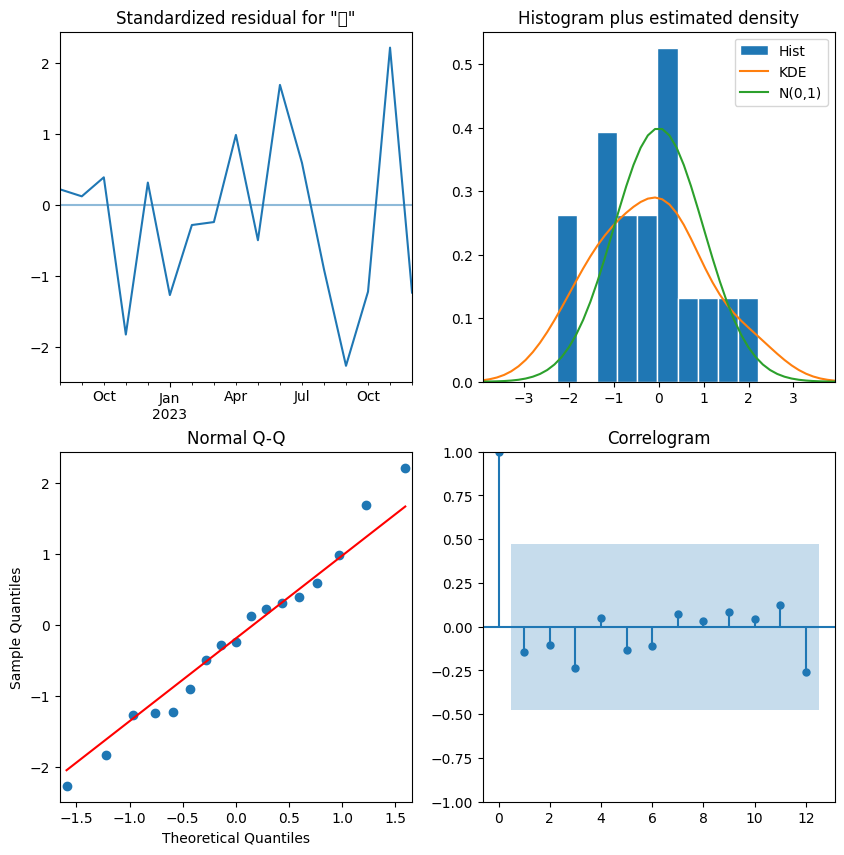

In [ ]:
sarimax_model_fit.plot_diagnostics(figsize=(10,10),lags=12);
plt.show

4　予測の可視化

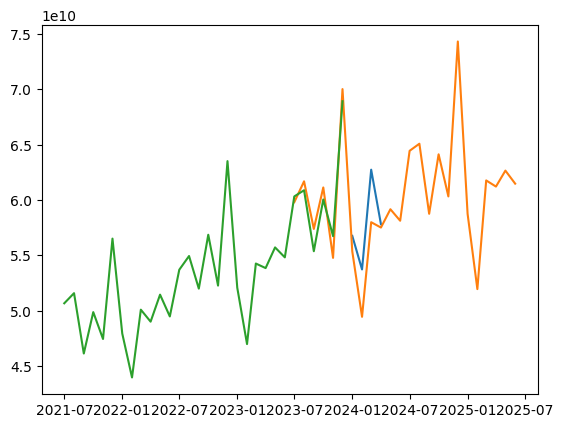

In [ ]:
pred_sarimax = sarimax_model_fit.get_prediction(start='2021-07-01', end = '2025-06-01')
#pred_sarimax_ci = pred.conf_int(alpha=0.05)
plt.plot(df_test)
plt.plot(pred_sarimax.predicted_mean[24:])
plt.plot(df_train)
#plt.plot(pred_sarimax_ci)
plt.show()

In [ ]:
#pred_sarimax = sarimax_model_fit.predict(start='2021-07-01', end = '2025-06-01')
#plt.plot(df_test)
#plt.plot(pred_sarimax)
#plt.plot(df_train)
#plt.show()

In [ ]:
pred_sarimax.predicted_mean[24:]

2023-07-01    5.980675e+10
2023-08-01    6.169689e+10
2023-09-01    5.738928e+10
2023-10-01    6.114356e+10
2023-11-01    5.477507e+10
2023-12-01    7.003629e+10
2024-01-01    5.536763e+10
2024-02-01    4.944574e+10
2024-03-01    5.799931e+10
2024-04-01    5.751694e+10
2024-05-01    5.917231e+10
2024-06-01    5.813268e+10
2024-07-01    6.445539e+10
2024-08-01    6.509615e+10
2024-09-01    5.876164e+10
2024-10-01    6.413926e+10
2024-11-01    6.033112e+10
2024-12-01    7.434112e+10
2025-01-01    5.875396e+10
2025-02-01    5.195139e+10
2025-03-01    6.177696e+10
2025-04-01    6.122297e+10
2025-05-01    6.266460e+10
2025-06-01    6.148528e+10
Freq: MS, Name: predicted_mean, dtype: float64

番外編：階差（トレンドやARIMAの'd'に該当する）を特定する。
DiffやSTLを活用して、時系列分析の前処理を行う。
また、メモとして、時系列分析【階差についての研究/メモ】にも追記している。
https://colab.research.google.com/drive/16LMnzcsoAMeKMw2guePtqXd6wGLJ42Tg


参考文献）
Pythonで時系列解析・超入門（その1）
時系列データに対する3つの特徴把握方法
（変動成分・定常性・コレログラム）
https://www.salesanalytics.co.jp/datascience/datascience085/


Pythonで学ぶADF検定の基礎
https://www.salesanalytics.co.jp/datascience/datascience227/


Pythonで時系列解析・超入門（その4）
https://www.salesanalytics.co.jp/datascience/datascience091/


In [ ]:
df

,合計金額
日付,
2021-07-01,5.066798e+10
2021-08-01,5.158333e+10
2021-09-01,4.612613e+10
2021-10-01,4.986985e+10
2021-11-01,4.744071e+10
2021-12-01,5.651672e+10
2022-01-01,4.793706e+10
2022-02-01,4.396037e+10
2022-03-01,5.009087e+10


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフのスタイル
plt.rcParams['figure.figsize'] = [12, 9] # グラフサイズ設定

# ライブラリーの読み込み
import pandas as pd
import numpy as np
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフのスタイル
plt.rcParams['figure.figsize'] = [12, 9] # グラフサイズ設定

df_result = adfuller(df)
print('ADF statistic: %f' % df_result[0])
print('p-value:%f' % df_result[1])

ADF statistic: -3.733268
p-value:0.003669


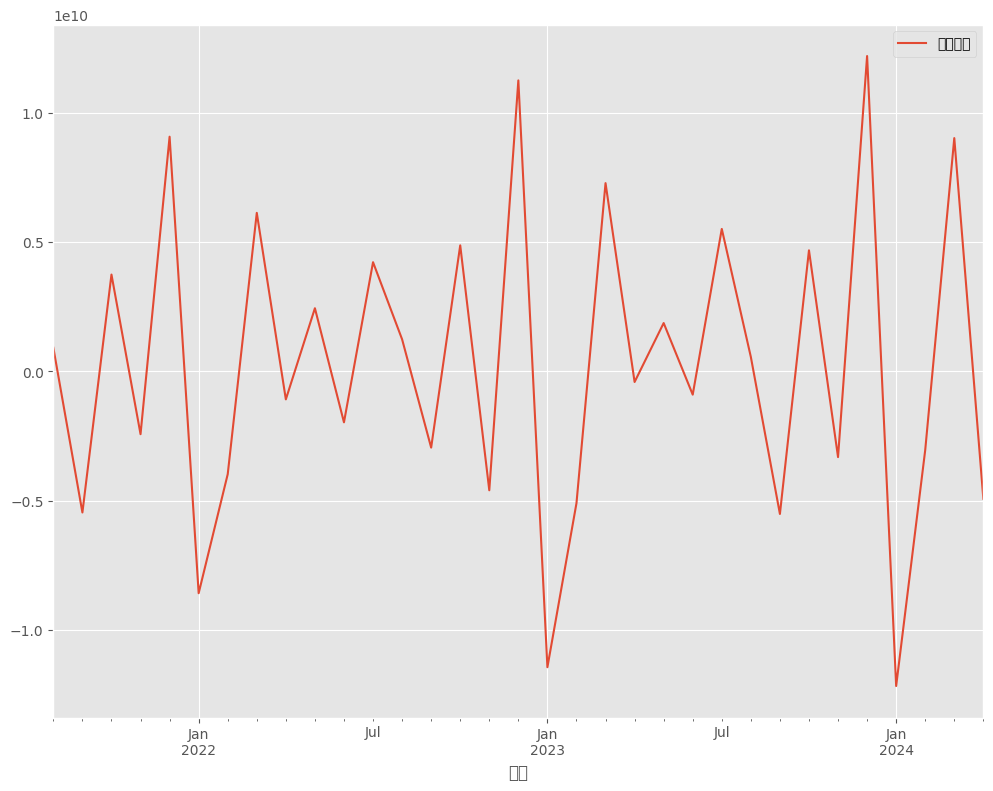

ADF Statistic: -8.197709
p-value: 0.000000


In [ ]:
data_diff = df.diff().dropna()
data_diff.plot()
plt.show()

df_result = adfuller(data_diff)
print('ADF Statistic: %f' % df_result[0])
print('p-value: %f' % df_result[1])

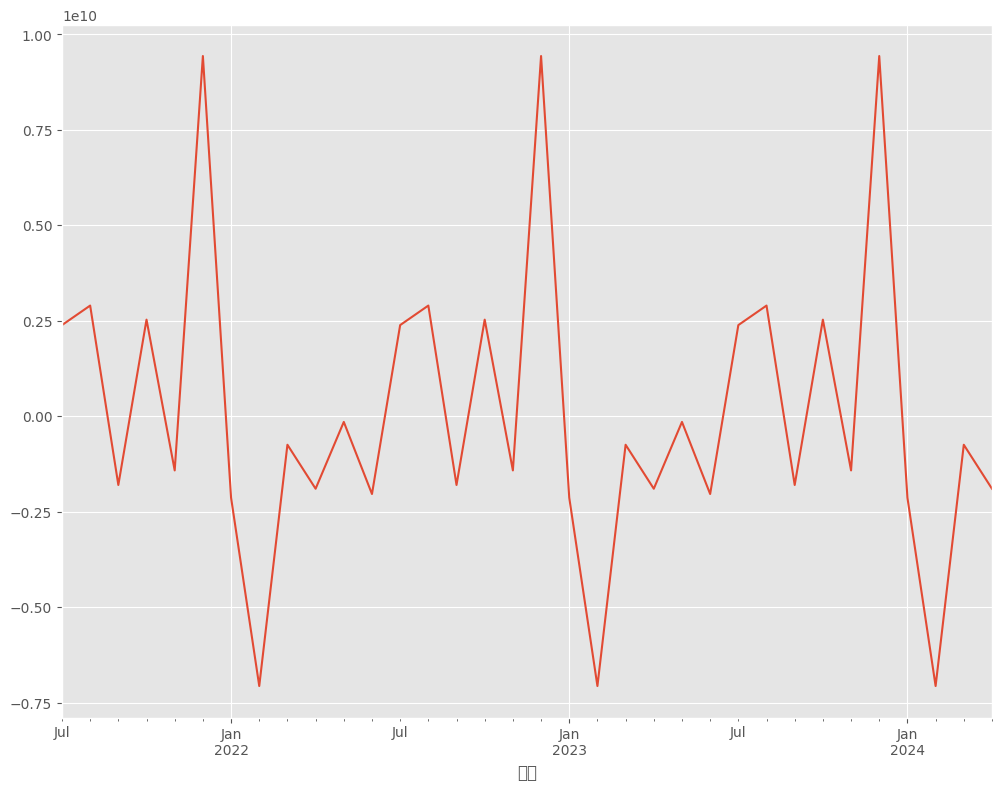

In [ ]:
df_result = seasonal_decompose(df, period=12)

df_result.seasonal.plot()
plt.show()

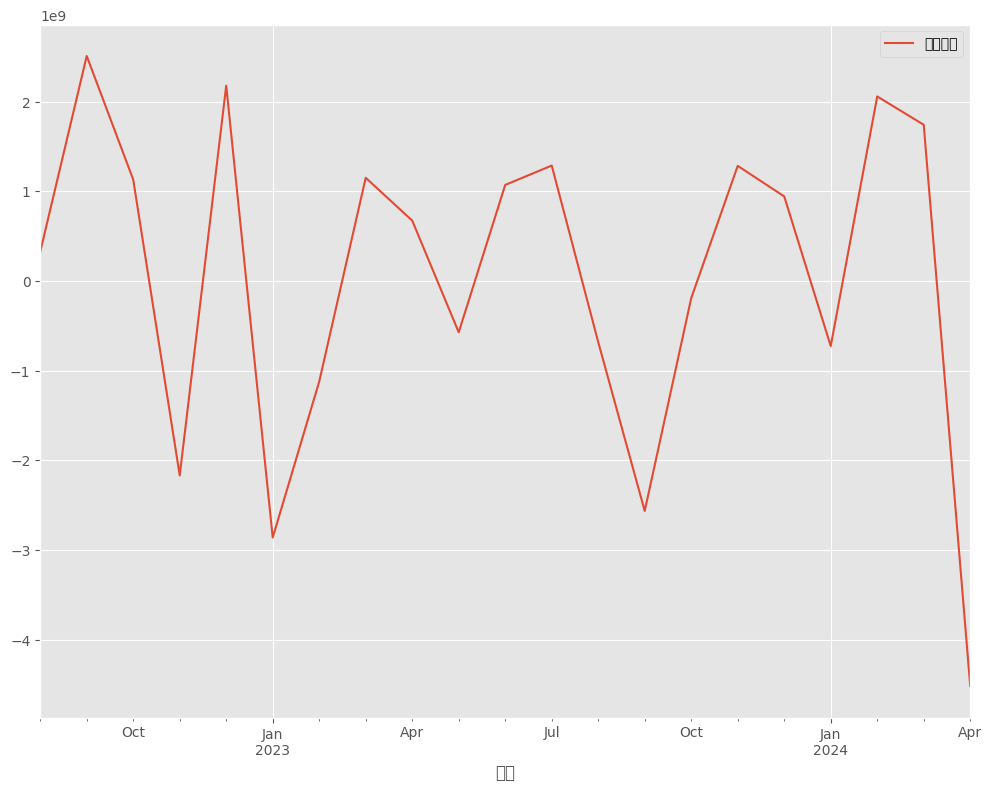

ADF Statistic: -4.561874
p-value: 0.000152


In [ ]:
data_diff_s = data_diff.diff(12).dropna()
data_diff_s.plot()
plt.show()

df_result = adfuller(data_diff_s)
print('ADF Statistic: %f' % df_result[0])
print('p-value: %f' % df_result[1])

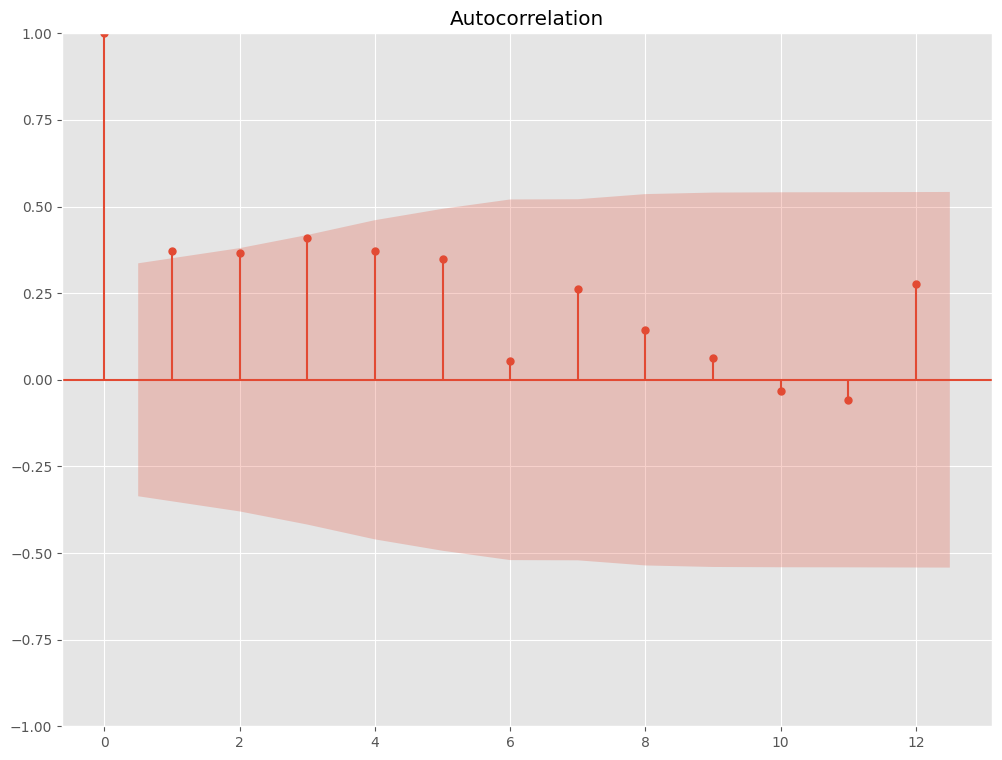

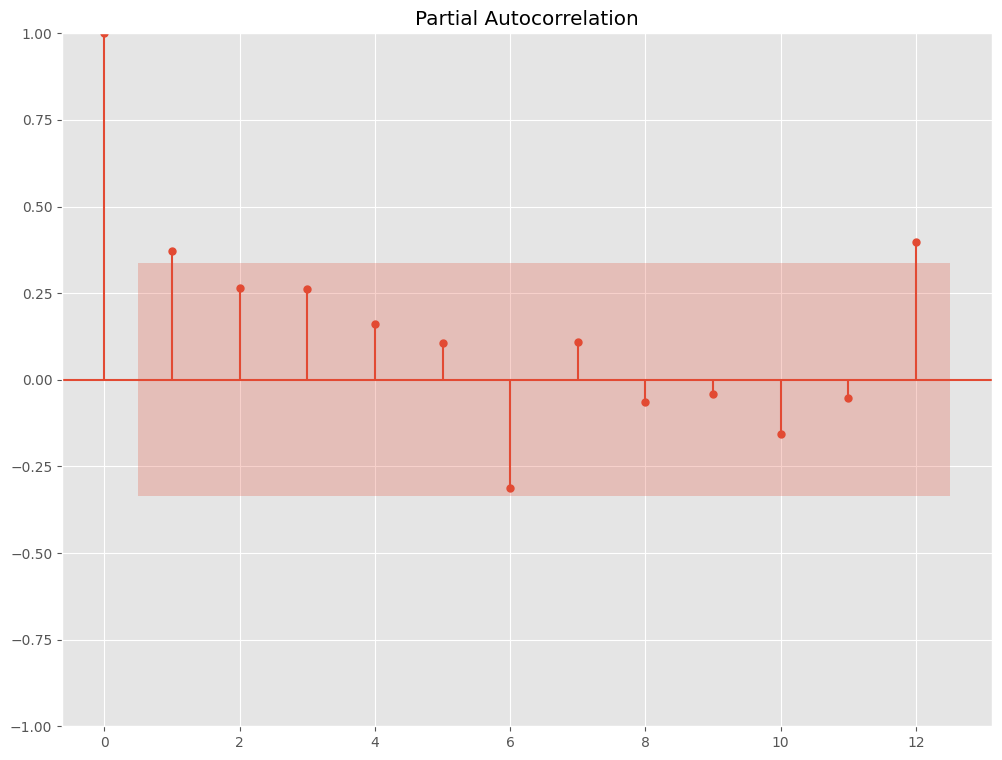

In [ ]:
acf = plot_acf(df, lags=12)
pacf = plot_pacf(df, lags=12)

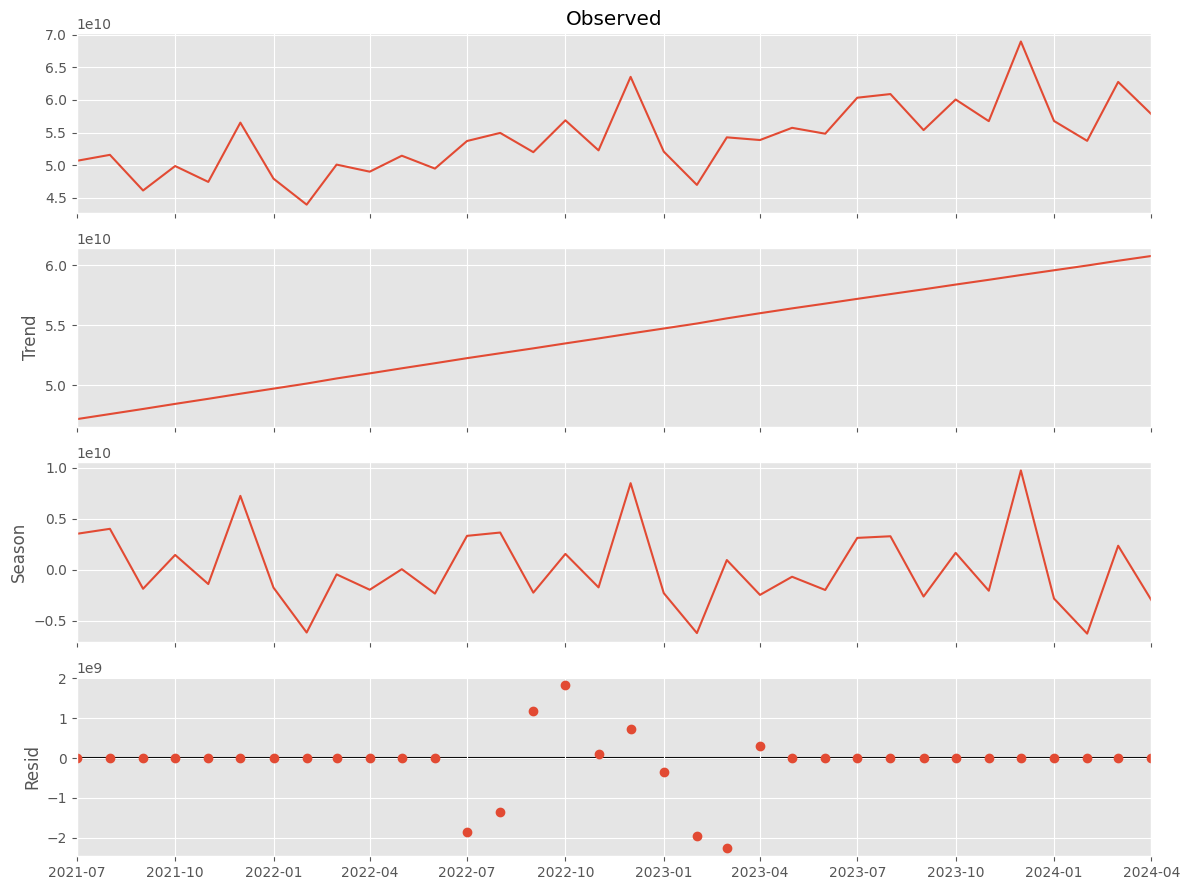

In [ ]:
stl = STL(df, period=12, robust=True).fit()

stl.plot()
plt.show()